# 7: Multi-sample integration task for mouse breast cancer

HiSTaR can process Correct the batch effect. In this tutorial, we use Mouse Breast Cancer dataset to introduce the analysis.<br>
Mouse breast cancer data comes from STGMVA https://zenodo.org/records/8141084<br>
The complete experimental dataset is available here https://zenodo.org/records/15599070<br>

## Loading package

In [1]:
import scanpy as sc
import torch
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
torch.set_default_dtype(torch.float64)

In [2]:
import HiSTaR
random_seed = 2023
HiSTaR.fix_seed(random_seed)

In [3]:
import matplotlib as mpl
mpl.rcParams.update({
    'font.family': 'Arial',             
    'axes.labelweight': 'bold',         
    'axes.titleweight': 'bold',         
    'axes.titlesize': 12,               
    'axes.titlelocation': 'left',       
    'figure.constrained_layout.use': True,  
    'figure.dpi': 300,                   
    'savefig.dpi': 300,
})

mclust_palette = [
    "#F3766E", "#5BB300", "#2E96FF", "#C655D9",
    "#FFB549", "#00C6EA", "#9B8500", "#009E73"
]

## Reading ST data and showing two sections of mouse brain data

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# read data
file_fold = '../data/'
adata = sc.read_h5ad(file_fold + 'mouse_breast_cancer_sample1_section1&2.h5ad')
adata.var_names_make_unique()

Text(0.0, 1.0, 'Aligned image')

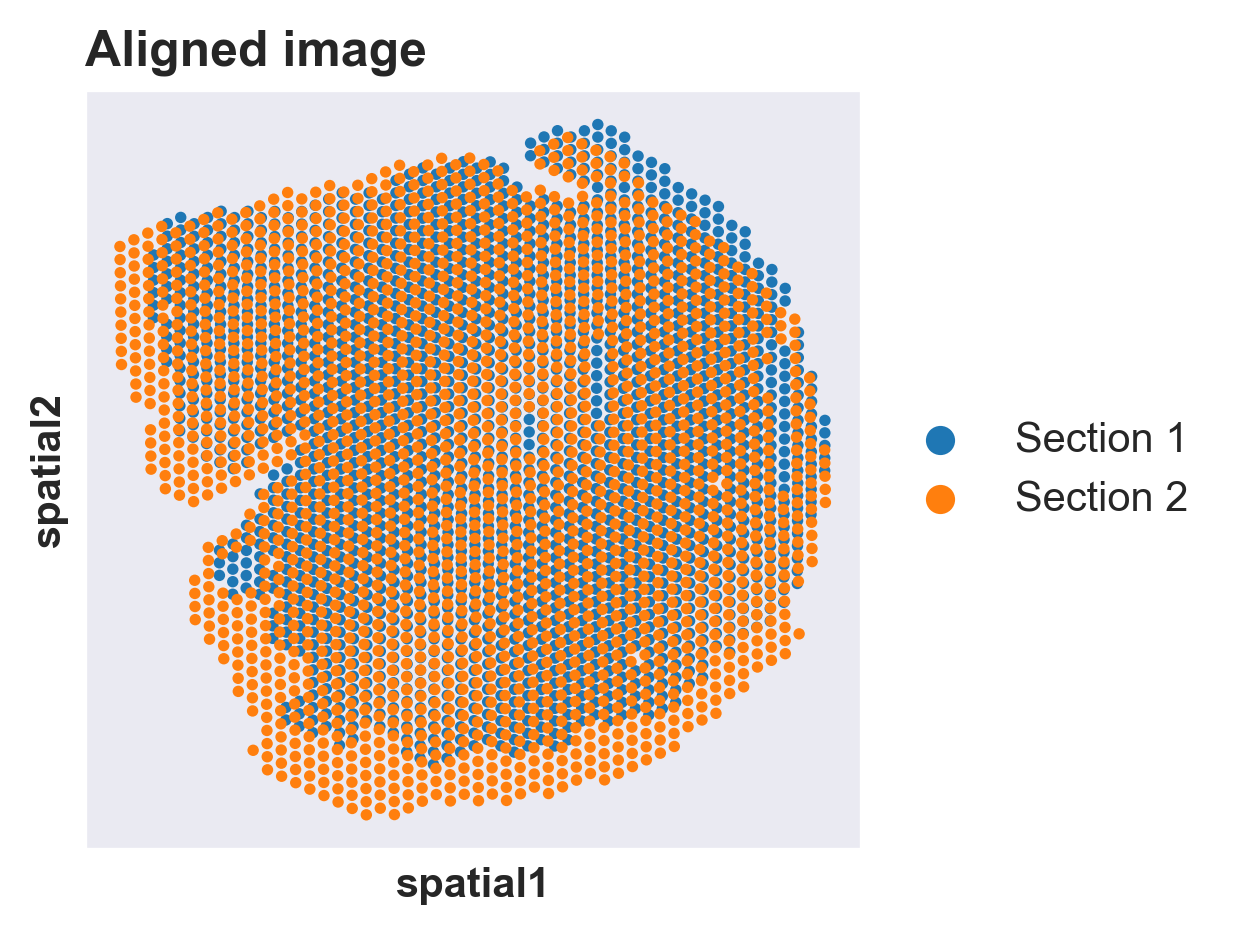

In [5]:
plt.rcParams["figure.figsize"] = (4, 3)
adata.obsm['spatial'][:, 1] = -1*adata.obsm['spatial'][:, 1]
adata.obs['data'].replace({'S1':'Section 1', 'S3':'Section 2'}, inplace=True)
ax = sc.pl.embedding(adata, basis='spatial', color='data', s=30, show=False)
ax.set_title('Aligned image')
# plt.savefig(
#     'BC_Batch.png',
#     dpi=300,
#     bbox_inches='tight',
#     facecolor='white', 
#     edgecolor='white'
# )

In [6]:
adata.layers['count'] = adata.X.toarray()
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=2000)
adata = adata[:, adata.var['highly_variable'] == True]
sc.pp.scale(adata)

from sklearn.decomposition import PCA
adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X

In [7]:
graph_dict = HiSTaR.graph_construction(adata, 12)

In [8]:
adata

AnnData object with n_obs × n_vars = 3818 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'data'
    var: 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'data_colors', 'hvg'
    obsm: 'spatial', 'X_pca'
    layers: 'count'

## Training HiSTaR

In [9]:
histar_net = HiSTaR.histar(adata.obsm['X_pca'], graph_dict, device=device, gcn_hidden2=16, lambda_sim=0.88)
histar_net.train()
histar_feat, _, _, _ = histar_net.process()
adata.obsm['HiSTaR'] = histar_feat

## Clustering

In [10]:
#HiSTaR.configure_r_environment()   # If you encounter problems loading R packages, you can manually configure your path in this function.

In [11]:
HiSTaR.mclust_R(adata, n_clusters=10, use_rep='HiSTaR', key_added='HiSTaR')

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 3818 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'data', 'HiSTaR'
    var: 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'data_colors', 'hvg'
    obsm: 'spatial', 'X_pca', 'HiSTaR'
    layers: 'count'

## Visualization

### Batch effect removal figure

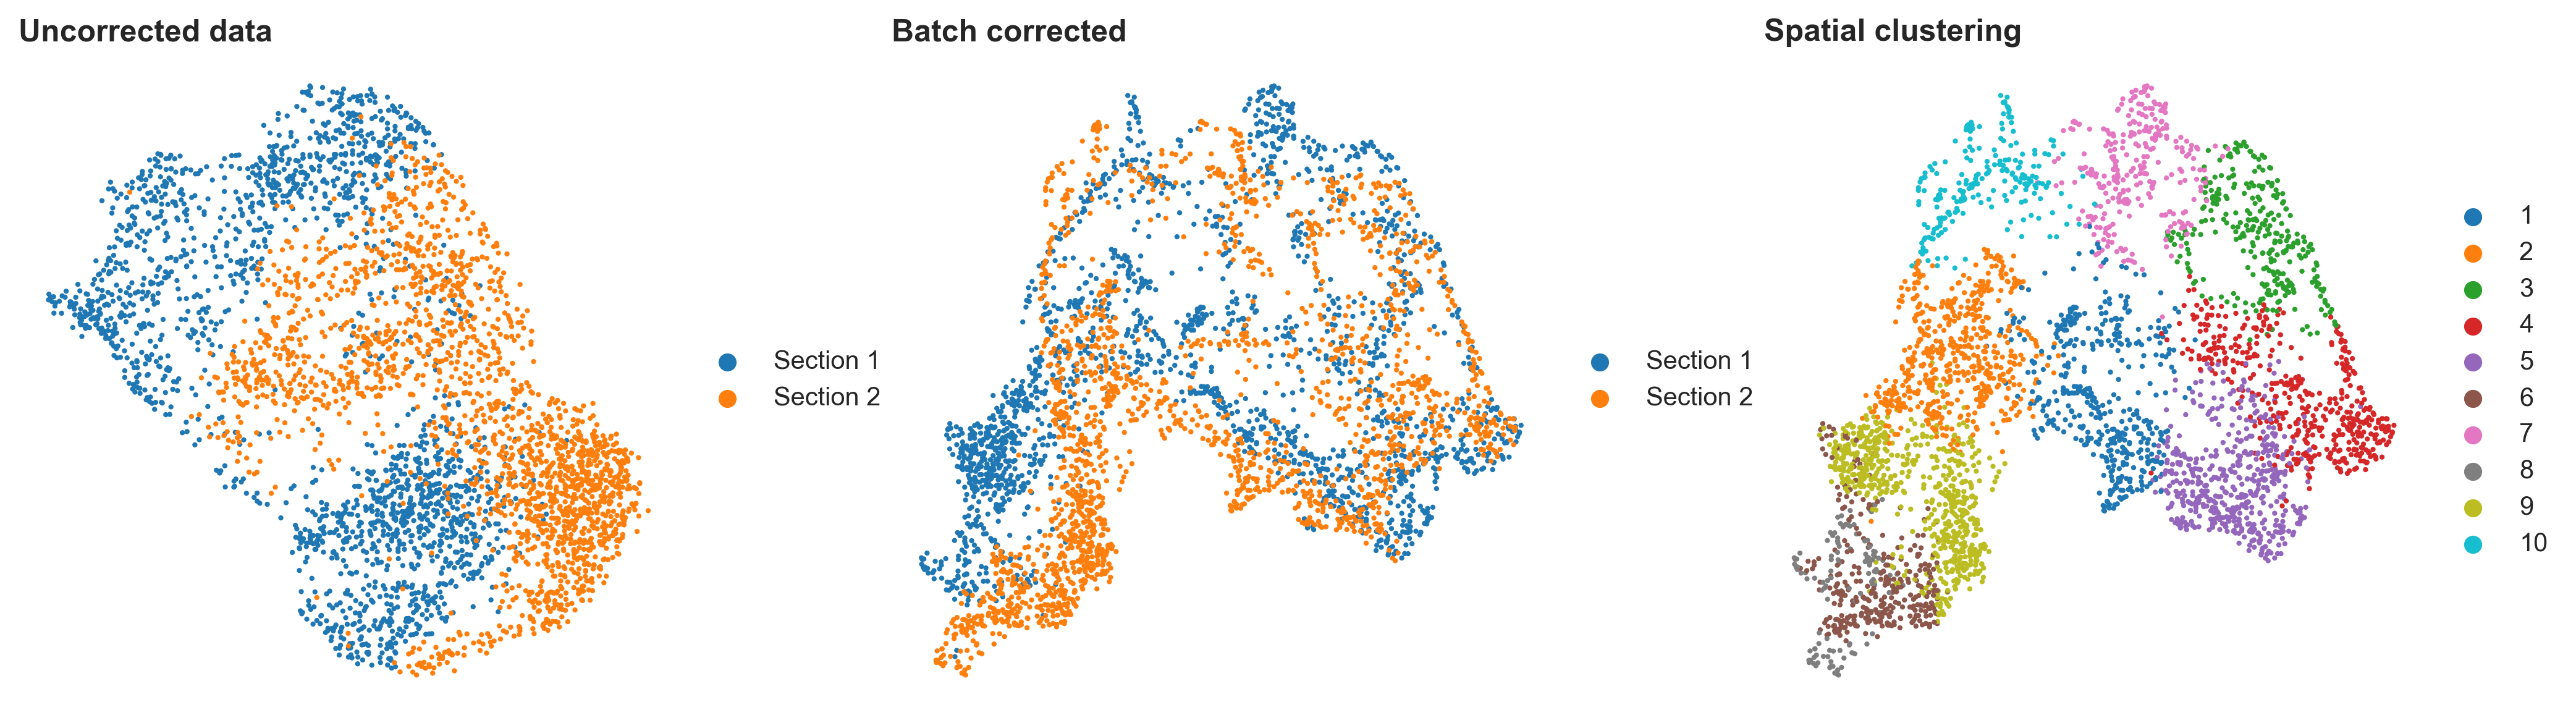

In [12]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

fig, ax_list = plt.subplots(1, 3, figsize=(14, 4), facecolor='white')

sc.pp.neighbors(adata, use_rep='X_pca', metric='cosine')
sc.tl.umap(adata)

sc.pl.umap(
    adata,
    color='data',
    title='Uncorrected data',
    ax=ax_list[0],
    show=False,
    s=16,
    frameon=False
)

sc.pp.neighbors(adata, use_rep='HiSTaR', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color='data',
    ax=ax_list[1],
    title='Batch corrected',
    show=False,
    s=16,
    frameon=False
)

sc.pl.umap(
    adata,
    color='HiSTaR',
    ax=ax_list[2],
    title='Spatial clustering',
    show=False,
    s=16,
    frameon=False
)

for ax in ax_list:
    ax.set_facecolor('white')

plt.tight_layout(w_pad=0.02)
# plt.savefig(
#     'BC_Batch_umap.png',
#     dpi=300,
#     bbox_inches='tight',
#     facecolor='white', 
#     edgecolor='white'   
# )

### Spatial clustering for two sections

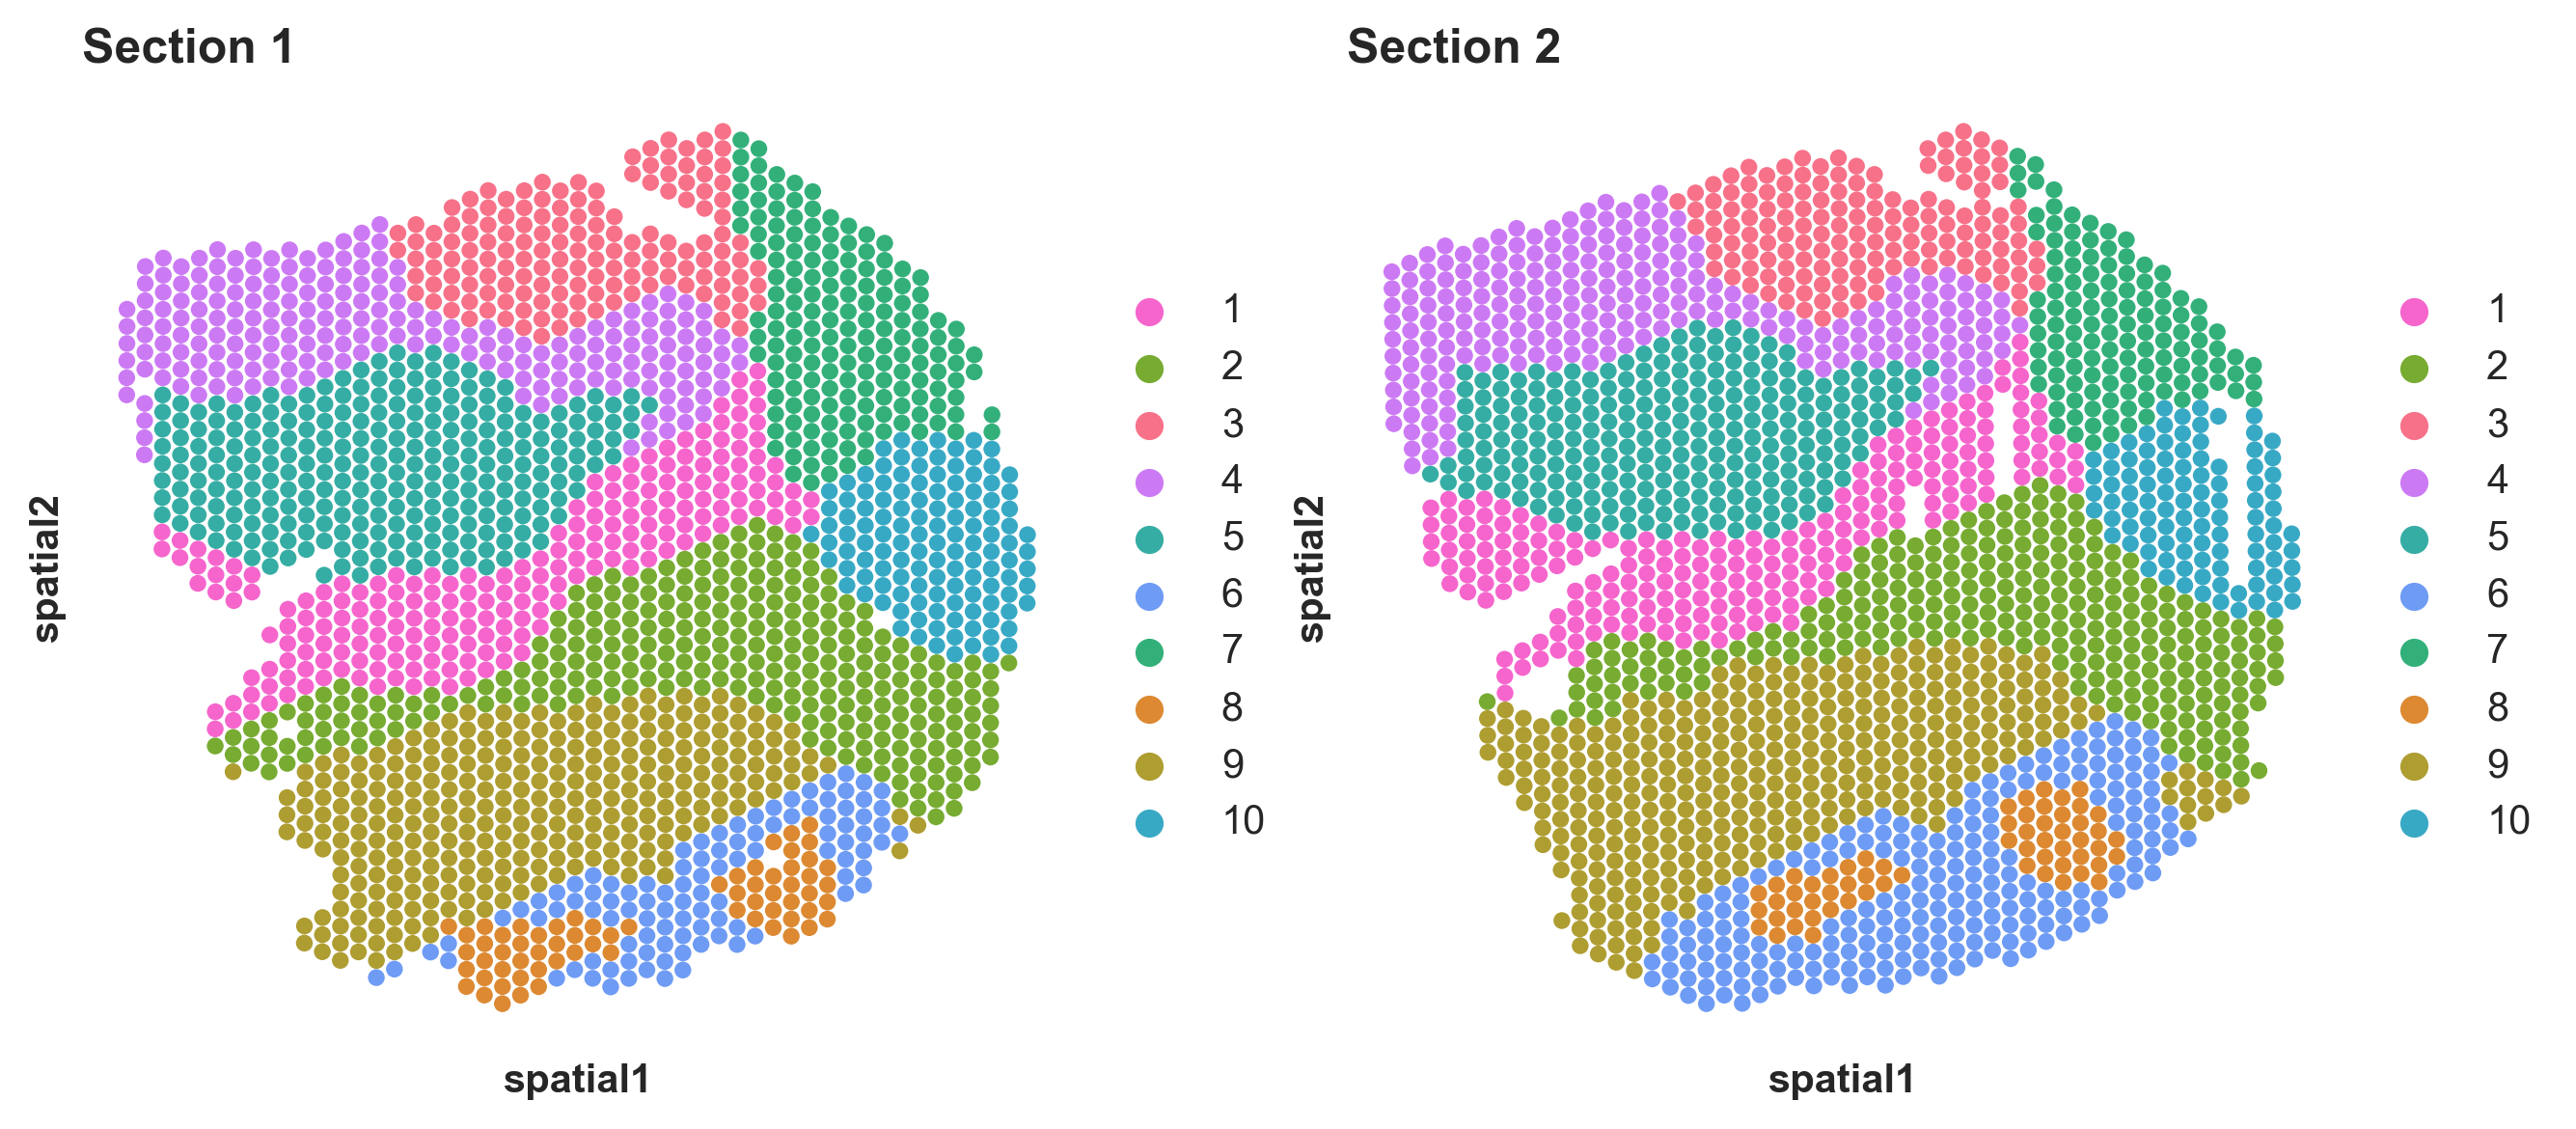

In [13]:
import seaborn as sns
adata_section1 = adata[adata.obs['data']=='Section 1', :]
adata_section2 = adata[adata.obs['data']=='Section 2', :]
rgb_values = sns.color_palette("husl", len(adata.obs['HiSTaR'].unique()))
color_fine = dict(zip(list(adata.obs['HiSTaR'].unique()), rgb_values))
fig, ax_list = plt.subplots(1, 2, figsize=(9, 4))
sc.pl.embedding(adata_section1,
            basis='spatial',
            color='HiSTaR',
            show = False,
            s=70,
            title='Section 1',
            palette=color_fine,
            ax = ax_list[0])

sc.pl.embedding(adata_section2,
            basis='spatial',
            color='HiSTaR',
            show = False,
            s=70,
            title = ['Section 2'],
            palette=color_fine,
            ax = ax_list[1])

plt.tight_layout(w_pad=0.3)
# plt.savefig('BC_Batch_spatial.png',dpi=300, bbox_inches='tight',facecolor='white')